# 1) Decision tree
Throughout the following exercises, we're going to construct and interpret a decision tree model with `scikit-learn`.

Topics of focus include:

* Relevant import statements
* Selecting an evaluation metric
* Encoding of categorical features as dummies
* Stratification during data splitting
* Fitting a model
* Model evaluation using precision, recall, and F1 score
* Plotting the decision tree and examining its splits

## 1.1) Modeling objective

The modeling objective is to build and test a **decision tree model** that uses **banking data** to predict whether a customer will churn. If a customer churns, it means they left the bank and took their business elsewhere. If we can predict customers who are likely to churn, we can take measures to retain them before they do. These measures could be promotions, discounts, or other incentives to boost customer satisfaction and, therefore, retention.

### 1.1.1) Model design and target variable

Our data dictionary shows that there is a column called `Exited`. This is a Boolean value that indicates whether or not a customer left the bank (0 = did not leave, 1 = did leave). This will be our target variable. In other words, for each customer, our model should predict whether they should have a 0 or a 1 in the Exited column.

This is a <span style="color:blue">**classification task**</span> because we are trying to predict on a binary class. Therefore, we will use a `DecisionTreeClassifier` model.

### 1.1.2) A note on modeling workflow and model selection

This notebook is used together with other notebooks that model the same data. Because of this, we will build all of our models across all of these notebooks, and model selection will take place in the final notebook. The champion model will be the one that performs best on the validation data. Only this final model will be evaluated using the test data.

This approach has a limitation. We are using the same data to tune the hyperparameters as we are using to perform model selection. This risks potentially overfitting the model to the validation data.

Ideally, with enough time and data, we'd tune the models' hyperparameters, then score all the models on separate validation data and perform model selection based on these scores. Finally, the champion model would be scored on the test holdout data to get an estimate of how the model can be expected to perform on new, unseen data.

## 1.2) Import Statements
Before we begin with the exercises and analyzing the data, we need to import all libraries and extensions required for this programming exercise. Throughout the notebook, we will be using numpy and pandas for operations, and matplotlib for plotting.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
# Decision Tree for Classification
from sklearn.tree import DecisionTreeClassifier        
# Function displays the splits of the tree
from sklearn.tree import plot_tree                        

from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## 1.3) Read the data

In [2]:
# Read in data :
file = "Churn_Modelling.csv"
df_original = pd.read_csv(file)
df_original.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df_original.shape

(10000, 14)

## 1.4) Examine the data

At this point in a typical data science project, we'd do a thorough exploratory data analysis (EDA) to better understand our data and what it's telling us. For the purposes of this lab, we will skip this.

In the steps that follow, we'll perform many of the same steps that we took to build our Naive Bayes model (another notebook). We'll redo them here to review them for good measure.

We'll begin by checking the balance of the classes in our target variable (`Exited`), as this will help us determine how to prepare our data. It will also inform our decision of what evaluation metric to use to select our final model.

In [4]:
df_original['Exited'].value_counts(normalize= True) * 100

0    79.63
1    20.37
Name: Exited, dtype: float64

The class of our target variable is split roughly 80/20. In other words, ~20% of the people in this dataset churned. This is an unbalanced dataset, but it's not extreme. We will preserve this ratio when we model.

## 1.5) Select an evaluation metric

The data contains 10,000 observations, and the class distribution is approximately 80/20.

Since we have some imbalance in our target classes, we know that if we measure model performance by **accuracy** alone, the model could predict 0 (no churn) 100% of the time and have an accuracy of ~80%. An accuracy of 80% might seem pretty good, but we know in this case it would be meaningless, because our model would fail to identify anybody who churned. Therefore, accuracy is not the best metric to use to evaluate our model's performance.

To determine which evaluation metric might be best, consider how our model might be wrong. There are two possibilities for bad predictions:

* <span style="color:red">**False positives**</span>: When the model predicts a customer will churn when in fact they won't.
* <span style="color:red">**False negatives**</span>: When the model predicts a customer will not churn when in fact they will.
As you know, there are a number of performance metrics aside from accuracy to choose from. Some of these include **precision**, **recall**, and **F1 score**. Let's examine these more closely, beginning with precision:

$$precision = \frac{\text{TP}}{\text{FP+TP}}$$
 
And recall:
$$recall = \frac{\text{TP}}{\text{FN+TP}}$$
 
Refer to the confusion matrix for a reminder on what the terms represent :

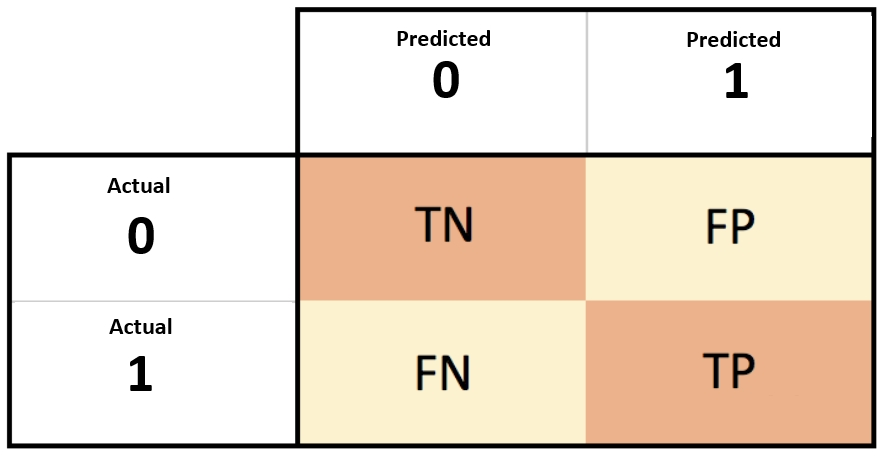

In [5]:
from IPython import display
display.Image("confusion matrix.jpg")

<span style="color:blue">**Precision**</span> represents the percentage of all our model's predicted positives that are true positives. This might not be the best metric for us to use, because it disincentivizes predicting someone will churn unless there is a high degree of certainty that they will. This could translate to a high rate of false negatives.

On the other hand, recall represents the percentage of all actual positives that the model identifies as such. This also might not be the best metric to use, because it rewards predicting someone will churn even if the likelihood of their doing so is very small. This could translate to a high rate of false positives.

**So which is worse, false positives or false negatives? Well, we'd first have to define what worse means. This is dependent on the details of the project that we're working on. For the sake of this exercise, let us suppose that we're defining it as the error that would cost the bank more money.**

We can quickly get an idea of how much money each customer who churns costs the bank by calculating the average balance of all customers who churned.

In [6]:
df_original.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [7]:
df_original[df_original["Exited"] == 1]['Balance'].mean()

91108.53933726068

This shows that the customers who churned each took with them **€91,108.54**, on average. That's a lot of money! This represents the average cost of the model predicting a false negative.

What's the cost of predicting a false positive? Well, it's the cost of whatever the incentive might be to convince someone to stay with the bank when they were going to stay regardless of whether or not they were incentived. We don't have a number for this, and even if it's probably less than €91,108.54, it still could be thousands of Euros per customer in lost revenue, depending on the details of the incentive.

Since correctly identifying customers who will churn is potentially very valuable, we could select <span style="color:blue">**recall**</span> as our most important metric. This might be a perfectly valid approach, depending on the specifics of the campaign. But this could also be problematic. After all, if we select a model based solely on recall, we could select a very biased model that predicts everyone to churn, but then 8,000 people would be given incentives needlessly.

**Since we don't know the exact cost of predicting a false negative, we'll make an assumption for this exercise. We'll assume that a metric that balances precision and recall is best. The metric that helps us achieve this balance is <span style="color:blue">**F1 score**</span>, which is defined as the harmonic mean of precision and recall.**

 
Again, there are many metrics to choose from. The important thing is that we make an informed decision that is based on our use case.
Now that we've decided on an evaluation metric, let's prepare the data for modeling.

## 1.6) Feature engineering

### 1.6.1) Feature selection

In this step, we'll prepare the data for modeling. These are the same steps as what we did for the Naive Bayes model.

We begin by dropping the columns that we wouldn't expect to offer any predictive signal to the model. These columns include `RowNumber`, `CustomerId`, and `Surname`. We'll drop these columns so they don't introduce noise to our model.

We'll also drop the `Gender` column, because we don't want our model to make predictions based on gender.

In [8]:
churn_df = df_original.drop(columns=["RowNumber", "CustomerId", "Surname", "Gender"], axis=1)
churn_df.head()

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,41,1,83807.86,1,0,1,112542.58,0
2,502,France,42,8,159660.80,3,1,0,113931.57,1
3,699,France,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,43,2,125510.82,1,1,1,79084.10,0


### 1.6.2) Feature transformation

Next, we'll dummy encode the `Geography` variable, which is categorical. There are three possible categories captured here: France, Spain, and Germany. When we call `pd.get_dummies()` on this feature, it will replace the `Geography` column with three new Boolean columns--one for each possible category contained in the column being dummied.

When we specify `drop_first='True'` in the function call, it means that instead of replacing `Geography` with three new columns, it will instead replace it with two columns. We can do this because no information is lost from this, but the dataset is shorter and simpler.

In this case, we end up with two new columns called `Geography_Germany` and `Geography_Spain`. We don't need a `Geography_France` column. Why not? Because if a customer's values in `Geography_Germany` and `Geography_Spain` are both 0, we'll know they're from France!

In [9]:
# Dummy encode categorical variables
churn_df = pd.get_dummies(churn_df, drop_first= True)
churn_df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,619,42,2,0.00,1,1,1,101348.88,1,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1


## 1.7) Split the data

It's time to split the data into **features** and **target variable**, and into **training data** and **test data**. We do this using the `train_test_split()` function. We'll put <span style="color:blue">25% of the data into our test set</span>, and use the remaining <span style="color:blue">75% to train</span> the model.

We don't forget to include the `stratify=y` parameter, as this is what ensures that the 80/20 class ratio of the target variable is maintained in both the training and test datasets after splitting.

Lastly, we set a random seed so we and others can reproduce our work.

In [10]:
# Define the y (target) variable
y= churn_df['Exited']

# Define the X (predictor) variables
X = churn_df.copy()
X = X.drop("Exited", axis= 1)

#Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify= y, random_state=42)

## 1.8) Baseline model

We'll first train a baseline model, just to get a sense of how predictive the data is and to give us scores that we can reference later. This will also show the process of instantiating and fitting the model, and then using it to make predictions. We'll predict on the test data.

In [11]:
# Instantiate the model
decision_tree = DecisionTreeClassifier(random_state=0)

# Fit the model to training data
decision_tree.fit(X_train, y_train)

# Make predictions on the test data
dt_pred = decision_tree.predict(X_test)

In [12]:
# Generate performance metrics
print("Accuracy:", "%.3f" % accuracy_score(y_test, dt_pred))
print("Precision:", "%.3f" % precision_score(y_test, dt_pred))
print("Recall:", "%.3f" % recall_score(y_test, dt_pred))
print("F1 Score:", "%.3f" % f1_score(y_test, dt_pred))

Accuracy: 0.790
Precision: 0.486
Recall: 0.503
F1 Score: 0.494


A comparison of <span style="color:blue">F1 scores</span> reveals that the decision tree is an improvement to the Naive Bayes model we built in another notebook (F1 = 0.456). For reference, here are the scores of both models:

### 1.8.1) Analysis of baseline model

#### <ins>Confusion matrix</ins>
Let's inspect the confusion matrix of our decision tree's predictions. First, we'll write a short helper function to help us display the matrix.

In [13]:
def conf_matrix_plot(model, x_data, y_data):
    '''
    Accepts as argument model object, X data (test or validate), and y data (test or validate). 
    Returns a plot of confusion matrix for predictions on y data.
    ''' 
  
    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)
  
    disp.plot(values_format='')  # `values_format=''` suppresses scientific notation
    plt.show()

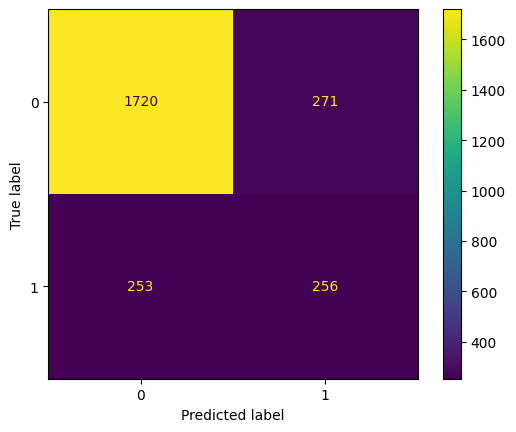

In [14]:
# Generate confusion matrix
conf_matrix_plot(decision_tree, X_test, y_test)

Notice from this confusion matrix that the model correctly predicts many true negatives. Of course, this is to be expected, given that the dataset is imbalanced in favor of negatives. When the model makes an error, it appears slightly more likely to predict a false positive than a false negative, but it's generally balanced. This is reflected in the precision and recall scores both being very close to each other.

#### <ins>Plotting the tree</ins>

Next, let's examine the splits of the tree. We'll do this by using the `plot_tree()` function that we imported. We pass to it our fit model as well as some additional parameters. Note that if we did not set `max_depth=2`, the function would return a plot of the entire tree, all the way down to the leaf nodes. This is intractable and unnecessary. **We're most interested in the splits nearest the root, because these tell us the most predictive features.**

`class_names` displays what the majority class of each node is, and `filled` colors the nodes according to their majority class.

Note that this plot represents how the tree grew from the **training data**. To make its predictions on the **test data**, the tree would simply pass each customer in the test data through its splits, from the root node all the way down to a leaf node.

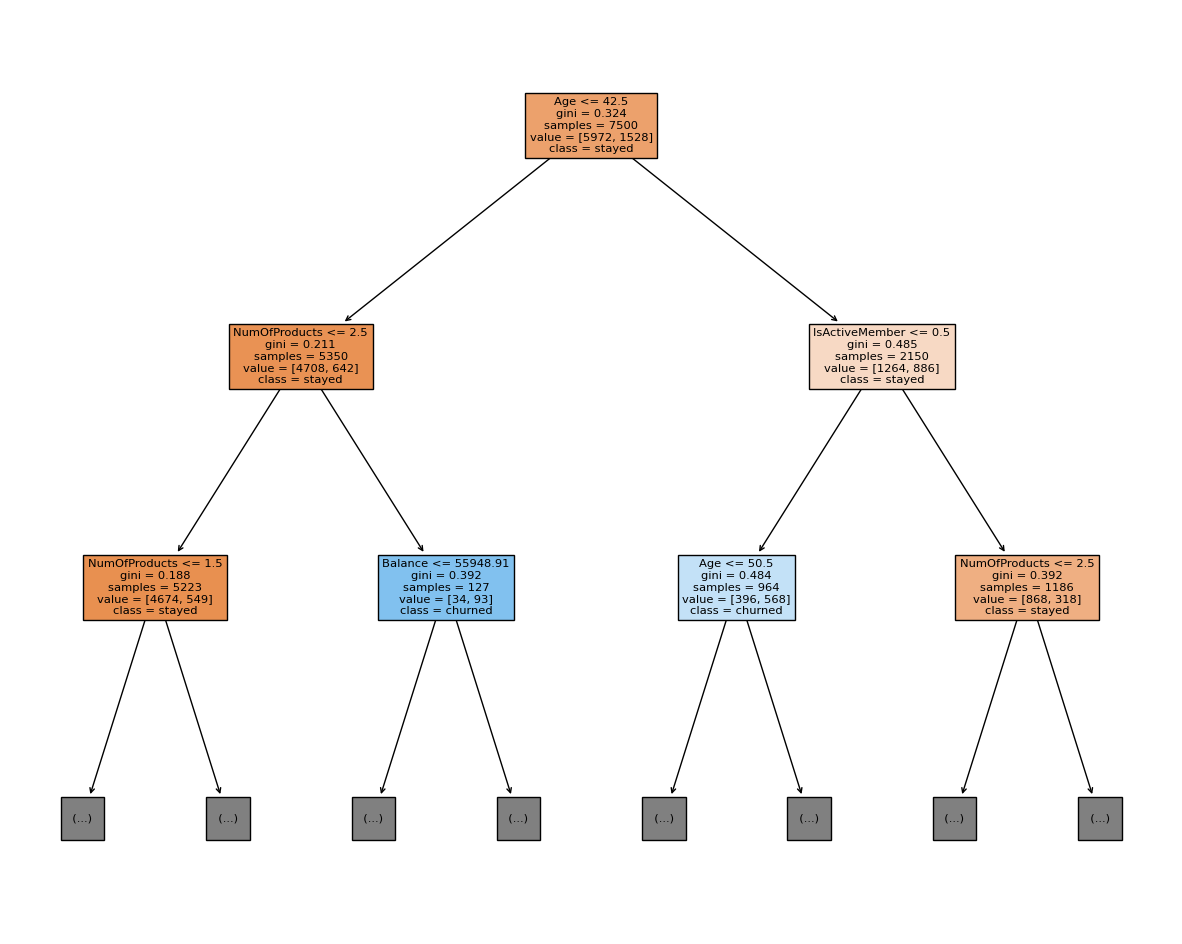

In [15]:
# Plot the tree
plt.figure(figsize=(15,12))
plot_tree(decision_tree, max_depth= 2, feature_names= X.columns,
          class_names={0 : "stayed", 1 : "churned"}, filled= True);

plt.show()

#### <ins>How do we read this plot?</ins>

* The <span style="color:red">**first line**</span> of information in each node is **the feature and split point that the model identified as being most predictive**. In other words, this is the question that is being asked at that split. For our root node, the question was: 

<span style="color:blue">**"Is the customer less than or equal to 42.5 years old?"**</span>

At each node, if the answer to the question it asks is *"yes,"* the sample would move to the child node on the left. If the answer is "no," the sample would go to the child node on the right.

* <span style="color:red">**gini**</span> refers to the node's **Gini impurity**. This is a way of measuring how "pure" a node is. The value can range from 0 to 0.5. A Gini score of 0 means there is no impurity—the node is a leaf, and all of its samples are of a single class. A score of 0.5 means the classes are all equally represented in that node.

* <span style="color:red">**samples**</span> is simply how many samples are in that node, and <span style="color:red">**value**</span> indicates how many of each class are in the node. Returning to the root node, we have `value = [5972, 1528]`. Notice that these numbers sum to 7,500, which is the number of samples in the node. This tells us that 5,972 customers in this node stayed (y=0) and 1,528 customers churned (y=1).

* Lastly, we have <span style="color:red">**class**</span> : This tells us the majority class of the samples in each node.

This plot tells us that, if we could only do a single split on a single variable, the one that would most help us predict whether a customer will churn is their `age`.

If we look at the nodes at depth one, we notice that the number of products and whether or not the customer is an active member also are both strong predictors (relative to the features we have) of whether or not they will churn.

**This is a good indication that it might be worthwhile to return to your EDA and examine these features more closely.**

Finally, it's worth noting that there is no single question that can be asked—for any feature—that would cause a majority of samples in one of the child nodes to be of class "churned." The tree must get to depth two (i.e., two questions must be asked) before this happens.

## 1.9) Tune and validate decision trees

Throughout the following exercises, we will use Python to **tune & cross-validate** a decision tree model with `scikit-learn`.

Topics of focus include:

* Using `GridSearchCV` to tune the following hyperparameters with cross-validation:
* `max_depth`
* `min_samples_leaf`

### 1.9.1 ) A note on modeling workflow and model selection

The tuned decision tree model in this notebook will be referenced in the subsequent notebooks for **random forest** and **XGBoost**, which model the same data. Because of this, we will build all of our models across all of these notebooks, and model selection will take place in the final notebook. The champion model will be the one that performs best on the **validation data**. Only this final model will be evaluated using the test data.

This approach has a limitation. We are using the same data to tune the hyperparameters as we are using to perform model selection. This risks potentially overfitting the model to the validation data.

Ideally, with enough time and data, we'd tune the models' hyperparameters, then score all the models on separate validation data and perform model selection based on these scores. Finally, the champion model would be scored on the **test holdout data** to get an estimate of how the model can be expected to perform on new, unseen data.

### 1.9.2) Import statements

The only additional import is `GridSearchCV` from scikit-learn's `model_selection` module. This is what we'll use to perform the grid search to tune the model's hyperparameters.

In [16]:
from sklearn.model_selection import GridSearchCV

### 1.9.3) Cross-validated hyperparameter tuning

<span style="color:blue">**Cross-validating**</span> a model using `GridSearchCV` can be done in a number of different ways. But all variations must fulfill the same general requirements. (Refer to the GridSearchCV documentation for further reading.)

The format presented below is step-wise, making it easier to follow.

<ins>**1 - Create a dictionary of hyperparameters to search over:**</ins>

* key = name of hyperparameter (string)
* value = values to search over (list)

In [17]:
# Assign a dictionary of hyperparameters to search over
tree_para = {'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50],
             'min_samples_leaf': [2, 5, 10, 20, 50]}

<ins>**2 - Create a dictionary of scoring metrics to capture.**</ins>

These metrics can be selected from `scikit-learn`'s built-in options or custom-defined. For this exercise, we'll capture **accuracy, precision, recall,** and **F1 score** so we can examine all of them. The metrics are entered as strings.

In [18]:
# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

<ins>**3 - Instantiate the classifier (and set the `random_state`)**</ins>

In [19]:
# Instantiate the classifier
tuned_decision_tree = DecisionTreeClassifier(random_state = 42)

<ins>**4 - Instantiate the GridSearchCV object.**</ins>
  
Pass as arguments:

* The classifier (`tuned_decision_tree`)

* The dictionary of hyperparameters to search over (`tree_para`)

* The dictionary of scoring metrics (`scoring`)

* The number of cross-validation folds you want (`cv=5`)

* The scoring metric that you want `GridSearch` to use when it selects the "best" model (i.e., the model that performs best on average over all validation folds) (`refit='f1'`)

The reason it's called `refit` is because once the algorithm finds the combination of hyperparameters that results in the **best average score across all validation folds**, it will then refit this model to all of the training data. Remember, up until now, with a 5-fold cross-validation, the model has only ever been fit on 80% (4/5) of the training data, because the remaining 20% was held out as a validation fold.

<ins>**5 - Fit the data (`X_train`, `y_train`) to the `GridSearchCV` object (clf)**</ins>

Depending on the number of different hyperparameters you choose, the number of combinations you search over, the size of your data, and your available computing resources, this could take a long time.

In [20]:
# Instantiate the GridSearch
clf = GridSearchCV(tuned_decision_tree, 
                   tree_para, 
                   scoring = scoring, 
                   cv=5, 
                   refit="f1")

# Fit the model
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50],
                         'min_samples_leaf': [2, 5, 10, 20, 50]},
             refit='f1', scoring={'precision', 'f1', 'accuracy', 'recall'})

Now that the model is **fit and cross-validated**, we can use the `best_estimator_` attribute to inspect the hyperparameter values that yielded the highest **F1 score** during cross-validation.

In [21]:
# Examine the best model from GridSearch
clf.best_estimator_

DecisionTreeClassifier(max_depth=8, min_samples_leaf=20, random_state=42)

The `best_score_` attribute returns the **best average F1 score across the different folds among all the combinations of hyperparameters**. Note that if we had set `refit='recall'` when we instantiated our `GridSearchCV` object earlier, then calling `best_score_` would return the best recall score, and the best parameters might not be the same as what they are in the above cell, because the model would be selected based on a different metric.

In [22]:
print("Best Avg. Validation Score :", "%.4f"% clf.best_score_)

Best Avg. Validation Score : 0.5607


Although the **F1 score** of 0.561 is significantly better than the **baseline model's F1 score of 0.494**, it's not a fair comparison, because the baseline model was scored on the test data and the tuned model was scored against validation folds that came from the training data.

Recall that when we ran our grid search, we specified that we also wanted to capture **precision, recall,** and **accuracy**. The reason for doing this is that it's difficult to interpret an **F1 score**. These other metrics are much more directly interpretable, so they're worth knowing.

The following cell defines a helper function that extracts these scores from the fit `GridSearchCV` object and returns a pandas dataframe with all four scores from the model with the best average F1 score during validation. This function will help us later when we want to add the results of other models to the table.

In [23]:
def make_results(model_name, model_object):
    '''
    Accepts as arguments a model name (your choice - string) and
    a fit GridSearchCV model object.
  
    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean F1 score across all validation folds.  
    '''

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(mean f1 score)
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame()
    table = table.append({'Model': model_name,
                        'F1': f1,
                        'Recall': recall,
                        'Precision': precision,
                        'Accuracy': accuracy
                        },
                        ignore_index=True
                       )
  
    return table

In [24]:
# Call the function on our model
result_table = make_results("Tuned Decision Tree", clf)

C:\Users\Badr\AppData\Local\Temp\ipykernel_10432\2409802599.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name,


We can save these results and open them in another notebook if we want to add to them. We'll save as a .csv file using `to_csv()`.

In [25]:
# Save results table as csv
result_table.to_csv("Results.csv")

In [26]:
# View the results 
result_table

,Model,F1,Recall,Precision,Accuracy
0,Tuned Decision Tree,0.560655,0.469255,0.701608,0.8504


These results show that our model's performance isn't great, but it's not terrible either. Maybe another kind of model will do better...